In [1]:
import numpy as np
import os.path

from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
DIR = "./"#"/Users/skmohan/Workspace/python/jupyter-notebook/udacity-deeplearning/"

def load_npy(prefix):
    xs = np.load( os.path.join(DIR, "svhn", "{}_preprocessed_img.npy".format(prefix)))
    labels = np.load( os.path.join(DIR, "svhn", "{}_preprocessed_labels.npy".format(prefix)))
    # RGB => Grayscale
    xs = np.dot(xs, [0.299, 0.587, 0.114]).reshape(xs.shape[0], 32, 32, 1) * 1./255
    # getting length only for now
    digits_len = to_categorical( np.array(list(map(len, labels)) , dtype=np.int), num_classes=7 )
    padded_labels = np.array(list(map(lambda x: list("{:0>6}".format(x)), labels) ) ).astype(np.int)
    digits = to_categorical(padded_labels).reshape(-1, 6, 10) # 6 digits, 10 classes
    #padded_labels = list(map(lambda x: list("{:0>6}".format(x))[-1], labels) ) 
    #last_digit = to_categorical( padded_labels,num_classes=10)
    return xs, [digits_len,] + [ digits[:, i, :] for i in range(6)]
    
def load_data():
    x_train, y_train = load_npy("train")
    x_test, y_test = load_npy("test")
    return x_train, y_train, x_test, y_test


In [3]:
x_train, y_train, x_test, y_test = load_data()

In [4]:
from keras.preprocessing.image import array_to_img

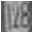

In [5]:
array_to_img(x_train[8])

In [6]:
np.argmax(y_train[0][8]), [np.argmax(y_train[i+1][8]) for i in range(6)]

(3, [0, 0, 0, 1, 2, 8])

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, Reshape, Input, Dot
from keras.layers.merge import multiply

img_input = Input(shape=(32,32,1))

cnn = Sequential()
cnn.add(Conv2D(16, (3, 3), input_shape=(32, 32, 1)))
cnn.add(Activation('relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(32, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn = cnn(img_input)
flat = Flatten()(cnn)

size = Dense(1024)(flat)
size = Activation('relu') (size)
size = Dropout(0.5) (size)
size = Dense(7)(size)
size_output = Activation('softmax', name="Length_Smax")(size)

size_input = Input(shape=(7,))
#merged = multiply([size, size_input])
#size_output = Lambda(lambda x: K.sum(x, axis=1))(merged)
size_merged = Dot(axes=1)([size_input, size_output])

digit_inputs = []
digit_outputs = []
digits_merged = []

for i in range(6):
    digit_output = Dense(10)(flat)
    digit_output = Activation('softmax', name="Digit_Last_Smax_{}".format(i))(digit_output)
    digit_input = Input(shape=(10,))
    #merged = multiply([d, digit_input])
    #digit_output = Lambda(lambda x: K.sum(x, axis=1))(merged)
    digit_merged = Dot(axes=1)([digit_input, digit_output])
    
    digit_inputs.append(digit_input)
    digit_outputs.append(digit_output)
    digits_merged.append(digit_merged)

output = multiply(digits_merged + [size_merged,])

In [8]:
from keras.models import Model

# use this for training
model = Model(inputs=[img_input, size_input] + digit_inputs, outputs=output)

# use this to predict
estimator = Model(inputs=[img_input], outputs=[size,] + digit_outputs)

model.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 2, 2, 64)      23744                                        
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 256)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          263168                                       
___________________________________________________________________________________________

In [9]:
from keras.callbacks import TensorBoard

In [ ]:
model.fit([ x_train, ] + y_train, np.ones(x_train.shape[0]),
          validation_split=0.2, 
          epochs=50,
          callbacks=[TensorBoard(log_dir='./logs-201608111242_2/')])

Train on 26721 samples, validate on 6681 samples
Epoch 1/50
26721/26721 [==============================] - 39s - loss: 4.6550 - acc: 0.1048 - val_loss: 3.8457 - val_acc: 0.1703

In [ ]:
model.fit([ x_train, ] + y_train, np.ones(x_train.shape[0]),
          validation_split=0.2, 
          epochs=5,
          callbacks=[TensorBoard(log_dir='./logs-201608111242_2/')])

Train on 26721 samples, validate on 6681 samples
Epoch 1/5
26721/26721 [==============================] - 41s - loss: 1.5096 - acc: 0.7168 - val_loss: 3.4702 - val_acc: 0.5110

In [17]:
def digit_loss(y_true, y_pred):
    loss = np.ones(y_true[0].shape[0])
    for digit_pred, digit_true in zip(y_pred, y_true):
        loss  = loss *  (digit_pred * digit_true).sum(axis=1)   
    return loss

def accuracy_single(y_true, y_pred):
    total_digits = 0
    correct_digits = 0
    for i in range(1,6):
        samples = np.argmax(y_true[0], axis=1) == i
        size = y_true[0][samples].shape[0]
        total_digits += size * i
        for j in range(6-i, 6):
            digit_true = np.argmax(y_true[j+1][samples], axis=1)
            digit_pred = np.argmax(y_pred[j+1][samples], axis=1)
            correct_digits += (digit_true == digit_pred).sum()
    #print("Digit Accuracy: {} / {} ({:.2%})".format(correct_digits, total_digits, correct_digits/total_digits))
    return correct_digits, total_digits

def accuracy_multi(y_true, y_pred):
    n = y_true[0].shape[0]
    seq_len = np.argmax(y_pred[0], axis=1) #[samples]

    seq_pred = np.sum( [ (seq_len > 6 - i)
                            * np.argmax(y_pred[i], axis=1) 
                            * 10**(6-i) for i in range(1,7) ], 
                axis=0)
    seq_true = np.sum([ np.argmax(y_true[i], axis=1) * 10**(6-i) for i in range(1,7)], axis=0)
    return (seq_pred == seq_true).sum(), n

def performance(y_true, y_pred):
    loss = digit_loss( y_true[1:], y_pred[1:] )
    print("Loss : {}".format( (loss).mean())) # XXX Not sure what this means
    correct_digits, total_digits = accuracy_single(y_true, y_pred)
    print("Accuracy (single): {:.2%} ({}/{})".format(correct_digits/total_digits, correct_digits, total_digits))
    correct_seq, total_seq = accuracy_multi(y_true, y_pred)
    print("Accuracy (seq): {:.2%} ({}/{})".format(correct_seq/total_seq, correct_seq, total_seq))

In [20]:
y_pred = estimator.predict(x_train)
performance(y_train, y_pred)

Loss : 0.7023555662440584
Accuracy (single): 82.51% (60442/73251)
Accuracy (seq): 76.32% (25492/33402)


In [21]:
y_pred = estimator.predict(x_test)
performance(y_test, y_pred)

Loss : 0.7389808120874901
Accuracy (single): 85.25% (24452/28682)
Accuracy (seq): 80.62% (10536/13068)


In [22]:
from IPython.display import display

Samples:  [9159, 2115, 11696, 10253, 10545, 4110, 6738]
Loss : 0.5590801314998329
Accuracy (single): 54.55% (12/22)
Accuracy (seq): 57.14% (4/7)
Predicted    108 (3) ✓
Actual       108 (3)


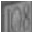

Predicted     47 (2) ✓
Actual        47 (2)


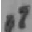

Predicted     56 (2) ✗
Actual        60 (2)


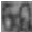

Predicted    321 (3) ✓
Actual       321 (3)


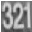

Predicted     25 (2) ✓
Actual        25 (2)


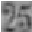

Predicted    165 (3) ✗
Actual     17661 (5)


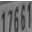

Predicted    165 (3) ✗
Actual     11150 (5)


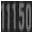

In [23]:
samples = [ 9159,  2115, 11696, 10253, 10545] + [4110, 6738] 
#samples = np.random.choice(x_test.shape[0], 5)

print("Samples: ", samples)
y_pred = estimator.predict(x_test[samples])
y_true = [ y_test[i][samples] for i in range(7) ]

performance( y_true, y_pred)

for s,sample in enumerate(samples):
    size_pred = np.argmax( y_pred[0][s] )
    num_pred = "".join(map(str, [np.argmax(y_pred[i+1][s]) for i in range(6 - size_pred, 6)] ))

    size_true = np.argmax( y_test[0][sample] )
    num_true = "".join(map(str, [np.argmax(y_true[i+1][s]) for i in range(6 - size_true, 6)] ))
    
    print( "Predicted {:>6} ({}) {}".format(num_pred, size_pred, "✓" if num_pred == num_true else "✗"))
    print( "Actual    {:>6} ({})".format(num_true, size_true))
    # print( num_pred == num_true )
    display(array_to_img(x_test[sample]))


In [24]:
estimator.save("./svhn/model_20170811.h5")

In [31]:
size = np.argmax( y_pred[0][4] )
num_pred = "".join(map(str, [np.argmax(y_pred[i+1][4]) for i in range(0, 6)] ))
size, num_pred

(2, '000025')

In [26]:
import pandas as pd

In [32]:
pd.DataFrame({"digit_{}".format(i): y_pred[i][4] for i in range(1, 7)})

,digit_1,digit_2,digit_3,digit_4,digit_5,digit_6
0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.861546e-12,2.149732e-13
1,2.053992e-27,2.007133e-25,1.233778e-27,5.558966e-15,7.500525e-08,8.899647e-08
2,7.748847e-27,5.573777e-26,1.107956e-28,1.675586e-15,9.999930e-01,8.274167e-18
3,2.543222e-26,3.751258e-28,6.085688e-28,9.577715e-12,2.843039e-06,3.597033e-07
4,7.346175e-28,1.305433e-26,1.385804e-26,1.167108e-24,3.024029e-09,3.004454e-10
5,3.570601e-26,9.833049e-27,1.083708e-27,9.336068e-18,3.895108e-10,9.999958e-01
6,2.411504e-27,7.067285e-27,1.610925e-26,8.696834e-17,1.408096e-11,3.662820e-06
7,1.687229e-28,4.232176e-27,4.457225e-29,1.231325e-16,3.976488e-06,2.437089e-14
8,3.757465e-25,2.964854e-27,8.949162e-28,1.219644e-22,7.361988e-09,4.619729e-11
9,7.524173e-28,5.296929e-27,6.887387e-29,9.364155e-22,6.469509e-08,1.326250e-08


In [33]:
from keras.models import load_model

registered_models = ["./svhn/model_20170807.h5", "./svhn/model_20170810.h5"]

for version in registered_models:
    print("="*5 + " " + version + " " + "="*5)
    modelv = load_model(version)
    y_pred_v = modelv.predict(x_test)
    performance(y_test, y_pred_v)

===== ./svhn/model_20170807.h5 =====
Loss : 0.23115104329161298
Accuracy (single): 33.23% (9531/28682)
Accuracy (seq): 25.61% (3347/13068)
===== ./svhn/model_20170810.h5 =====


/Users/skmohan/.virtualenv/tensorflow/lib/python3.5/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loss : 0.6120870040788884
Accuracy (single): 77.39% (22196/28682)
Accuracy (seq): 68.27% (8922/13068)
